In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
df = pd.read_csv('./Amazon.csv')

In [4]:
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df[['Close']]
MMS = MinMaxScaler()
df[['Close']] = MMS.fit_transform(df)

In [5]:
valid, test, train = np.split(df, [int(.2* len(df)), int (.4 * len(df))])

/home/itsakphyo/Desktop/AmazonStock/Amazon/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def create_seq(df, n_step):
    sequences = []
    labels = []
    for i in range(len(df)-n_step):
        sequence = df.iloc[i : i + n_step]
        label = df.iloc[i + n_step]
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [7]:
n_step = 10


train_X, train_y = create_seq(train, n_step)
valid_X, valid_y = create_seq(valid, n_step)
test_X, test_y = create_seq(test, n_step)

train_X = torch.tensor(train_X).float()
train_y = torch.tensor(train_y).float()
valid_X = torch.tensor(valid_X).float()
valid_y = torch.tensor(valid_y).float()
test_X = torch.tensor(test_X).float()
test_y = torch.tensor(test_y).float()

train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape

(torch.Size([3683, 10, 1]),
 torch.Size([3683, 1]),
 torch.Size([1221, 10, 1]),
 torch.Size([1221, 1]),
 torch.Size([1221, 10, 1]),
 torch.Size([1221, 1]))

In [8]:
class TimeseriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [9]:
train_dataset = TimeseriesDataset(train_X, train_y)
valid_dataset = TimeseriesDataset(valid_X, valid_y)
test_dataset = TimeseriesDataset(test_X, test_y)

batch_size = 16

load_train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
load_valid = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)
load_test = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layer):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_hidden_layer = num_hidden_layer
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_hidden_layer, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        bath_size = x.size(0)
        h0 = torch.zeros(self.num_hidden_layer, bath_size, self.hidden_size).to(device)
        a0 = torch.zeros(self.num_hidden_layer, bath_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, a0))
        out = self.fc(out[:, -1, :])
        return out

In [11]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')

    running_loss = 0.0
    
    for batch_index, batch in enumerate(load_train):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1: .8f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [12]:
def valid_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(load_valid):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    
    with torch.no_grad():
        out = model(X_batch)
        loss = loss_function(out, y_batch)
        running_loss += loss
        
    average_valid_loss = running_loss / len(load_valid)
    
    print('Valid Loss: {0: .8f}'.format(average_valid_loss))    
    print('*********************')

In [13]:
model = lstm(1, 20, 1)
model.to(device)
model

lstm(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [14]:
num_epoch = 150
lr = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(num_epoch):
    train_one_epoch()
    valid_one_epoch()

Epoch: 1
Batch 100, Loss:  0.02989852
Batch 200, Loss:  0.00021127
Valid Loss:  0.00000050
*********************
Epoch: 2
Batch 100, Loss:  0.00015996
Batch 200, Loss:  0.00016665
Valid Loss:  0.00000010
*********************
Epoch: 3
Batch 100, Loss:  0.00015487
Batch 200, Loss:  0.00016247
Valid Loss:  0.00000005
*********************
Epoch: 4
Batch 100, Loss:  0.00015984
Batch 200, Loss:  0.00013842
Valid Loss:  0.00000031
*********************
Epoch: 5
Batch 100, Loss:  0.00015934
Batch 200, Loss:  0.00013836
Valid Loss:  0.00000002
*********************
Epoch: 6
Batch 100, Loss:  0.00015906
Batch 200, Loss:  0.00014713
Valid Loss:  0.00000037
*********************
Epoch: 7
Batch 100, Loss:  0.00012586
Batch 200, Loss:  0.00013382
Valid Loss:  0.00000008
*********************
Epoch: 8
Batch 100, Loss:  0.00016576
Batch 200, Loss:  0.00013553
Valid Loss:  0.00000009
*********************
Epoch: 9
Batch 100, Loss:  0.00013150
Batch 200, Loss:  0.00012225
Valid Loss:  0.00000158
*****

Batch 100, Loss:  0.00005590
Batch 200, Loss:  0.00005293
Valid Loss:  0.00000005
*********************
Epoch: 74
Batch 100, Loss:  0.00005261
Batch 200, Loss:  0.00004698
Valid Loss:  0.00000007
*********************
Epoch: 75
Batch 100, Loss:  0.00004859
Batch 200, Loss:  0.00005745
Valid Loss:  0.00000020
*********************
Epoch: 76
Batch 100, Loss:  0.00005913
Batch 200, Loss:  0.00005222
Valid Loss:  0.00000015
*********************
Epoch: 77
Batch 100, Loss:  0.00005539
Batch 200, Loss:  0.00004914
Valid Loss:  0.00000000
*********************
Epoch: 78
Batch 100, Loss:  0.00004650
Batch 200, Loss:  0.00005485
Valid Loss:  0.00000011
*********************
Epoch: 79
Batch 100, Loss:  0.00006885
Batch 200, Loss:  0.00005085
Valid Loss:  0.00000001
*********************
Epoch: 80
Batch 100, Loss:  0.00004732
Batch 200, Loss:  0.00004935
Valid Loss:  0.00000001
*********************
Epoch: 81
Batch 100, Loss:  0.00005079
Batch 200, Loss:  0.00004888
Valid Loss:  0.00000021
******

Batch 100, Loss:  0.00005409
Batch 200, Loss:  0.00004107
Valid Loss:  0.00000046
*********************
Epoch: 146
Batch 100, Loss:  0.00005227
Batch 200, Loss:  0.00004944
Valid Loss:  0.00000002
*********************
Epoch: 147
Batch 100, Loss:  0.00004518
Batch 200, Loss:  0.00005123
Valid Loss:  0.00000002
*********************
Epoch: 148
Batch 100, Loss:  0.00005360
Batch 200, Loss:  0.00004555
Valid Loss:  0.00000000
*********************
Epoch: 149
Batch 100, Loss:  0.00004411
Batch 200, Loss:  0.00005842
Valid Loss:  0.00000001
*********************
Epoch: 150
Batch 100, Loss:  0.00005262
Batch 200, Loss:  0.00005000
Valid Loss:  0.00000002
*********************


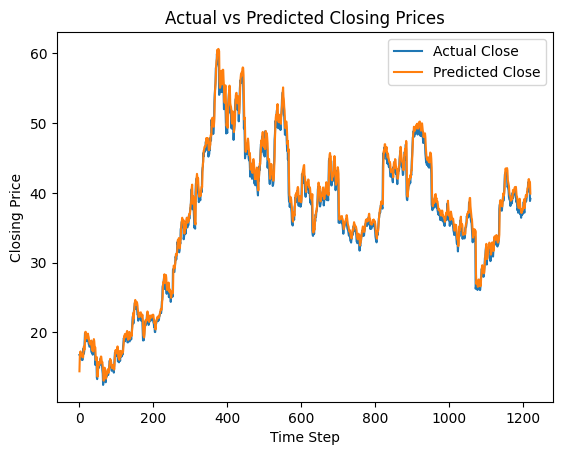

In [15]:
with torch.no_grad():
    predicted = model(test_X.to(device)).to('cpu').numpy()

predicted = MMS.inverse_transform(predicted)
test_y = MMS.inverse_transform(test_y)
plt.plot(test_y, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Time Step')
plt.ylabel('Closing Price')
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.show()